In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np 
import pandas as pd 


# Any results you write to the current directory are saved as output.

from sklearn.model_selection import train_test_split # train-test split
from sklearn.metrics import confusion_matrix, classification_report # classification metrics
from imblearn.over_sampling import SMOTE # SMOTE
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler # scaling methods


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
import gc
import matplotlib.pyplot as plt


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
app_train = pd.read_csv("/content/drive/MyDrive/ML sujet 7/projet ML -Sujet7/application_train.csv")
app_test = pd.read_csv("/content/drive/MyDrive/ML sujet 7/projet ML -Sujet7/application_test.csv")

In [ ]:
print(app_train.shape, app_test.shape)

(307511, 122) (48744, 121)


In [ ]:
app_test.head(3)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,...,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0


In [ ]:
app_train.head(3)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
app_train["source"] = "train"
app_test["source"] = "test"

## ***One hot encoding phase , concatenate them both to get the process at once***

In [ ]:
application = pd.concat([app_train, app_test], axis=0, ignore_index=True)
application.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,source
0,100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,train
1,100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,train
2,100004,0.0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,train
3,100006,0.0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,train
4,100007,0.0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,train


In [ ]:
application['TARGET'].dtypes

dtype('float64')

In [ ]:
application['TARGET'].isnull().sum()

48744

In [ ]:
application['TARGET']=application['TARGET'].astype(int)

ValueError: ignored

In [ ]:
application.head(5)

***Find columns with a lot of missing data and remove some of them***

In [ ]:
missing_cols_prcnt = app_train.isnull().sum()/app_train.shape[0] * 100
high_missing_values = missing_cols_prcnt[missing_cols_prcnt > 50]
high_missing_values_index = high_missing_values.index.tolist()
high_missing_values[:5]

OWN_CAR_AGE         65.990810
EXT_SOURCE_1        56.381073
APARTMENTS_AVG      50.749729
BASEMENTAREA_AVG    58.515956
YEARS_BUILD_AVG     66.497784
dtype: float64

In [ ]:
correlations = app_train.corr()['TARGET'].sort_values()
corr_missing_cols = correlations.reindex(high_missing_values_index).sort_values()
missing_cols_to_be_dropped = corr_missing_cols.index.difference(corr_missing_cols[(corr_missing_cols > 0.02) | (corr_missing_cols < -0.02)].index).tolist()
len(missing_cols_to_be_dropped)

19

In [ ]:
missing_cols_to_be_dropped

['BASEMENTAREA_MODE',
 'COMMONAREA_AVG',
 'COMMONAREA_MEDI',
 'COMMONAREA_MODE',
 'ENTRANCES_AVG',
 'ENTRANCES_MEDI',
 'ENTRANCES_MODE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'LANDAREA_AVG',
 'LANDAREA_MEDI',
 'LANDAREA_MODE',
 'NONLIVINGAPARTMENTS_AVG',
 'NONLIVINGAPARTMENTS_MEDI',
 'NONLIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_AVG',
 'NONLIVINGAREA_MEDI',
 'NONLIVINGAREA_MODE',
 'WALLSMATERIAL_MODE']

In [ ]:
application = application.drop(missing_cols_to_be_dropped, axis=1)
application.shape

(356255, 104)

***Separate numerical and categorical data***

In [ ]:
#Make sure 'TARGET' and 'Source' are excluded
categorical_vars = [f for f in application.columns if f!='TARGET' and f!='source' and application[f].dtype=="object"]
categorical_vars

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'EMERGENCYSTATE_MODE']

In [ ]:
application[categorical_vars].head(7)

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,EMERGENCYSTATE_MODE
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,No
1,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,MONDAY,School,No
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Government,NaN
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,NaN
4,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,THURSDAY,Religion,NaN
5,Cash loans,M,N,Y,"Spouse, partner",State servant,Secondary / secondary special,Married,House / apartment,Laborers,WEDNESDAY,Other,NaN
6,Cash loans,F,Y,Y,Unaccompanied,Commercial associate,Higher education,Married,House / apartment,Accountants,SUNDAY,Business Entity Type 3,NaN


In [ ]:
#Check once more that all numerical columns are indeed continuous and not discrete
numerical_vars = [f for f in application.columns if f!='TARGET' and f!='source' and application[f].dtype!="object"]
numerical_vars

['SK_ID_CURR',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BUILD_AVG',
 'ELEVATORS_AVG',
 'FLOORSMAX_AVG',
 'FLOORSMIN_AVG',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BUILD_MODE',
 'ELEVATORS_MODE',
 'FLOORSMAX_MODE',
 'FLOORSMIN_MODE',
 'LIVINGAPARTMEN

***DAYS_EMPLOYED discrepancy***

In [ ]:
application["DAYS_EMPLOYED_ANOMALY"] = 0
application["DAYS_EMPLOYED_ANOMALY"].loc[application[application["DAYS_EMPLOYED"] > 0]["DAYS_EMPLOYED"].index] = 1
application["DAYS_EMPLOYED"].loc[application[application["DAYS_EMPLOYED"] > 0]["DAYS_EMPLOYED"].index] = 0
application[["DAYS_EMPLOYED", "DAYS_EMPLOYED_ANOMALY"]].head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,DAYS_EMPLOYED,DAYS_EMPLOYED_ANOMALY
0,-637,0
1,-1188,0
2,-225,0
3,-3039,0
4,-3038,0


***XNA represents null in categorical cols***

In [ ]:
xna_cols = []
for c in categorical_vars:
    if application[c][application[c]=='XNA'].shape[0] > 0:
        xna_cols.append(c)
        
for c in xna_cols:
    application[c] = application[c].replace('XNA', np.nan)

***Amt credit missing values imputation***

In [ ]:
application[["AMT_CREDIT", "AMT_GOODS_PRICE"]].describe()

,AMT_CREDIT,AMT_GOODS_PRICE
count,3.562550e+05,3.559770e+05
mean,5.877674e+05,5.280200e+05
std,3.986237e+05,3.660650e+05
min,4.500000e+04,4.050000e+04
25%,2.700000e+05,2.340000e+05
50%,5.002110e+05,4.500000e+05
75%,7.975575e+05,6.750000e+05
max,4.050000e+06,4.050000e+06


In [ ]:
application[["AMT_CREDIT", "AMT_GOODS_PRICE"]].isnull().sum()

AMT_CREDIT           0
AMT_GOODS_PRICE    278
dtype: int64

In [ ]:
missing_goods_price_indices = application[application["AMT_GOODS_PRICE"].isnull()].index
norm_factor = np.mean(application["AMT_GOODS_PRICE"])/np.mean(application["AMT_CREDIT"])

In [ ]:
#Replacing the missing values of AMT_GOODS_PRICE
application.loc[missing_goods_price_indices, "AMT_GOODS_PRICE"] = application.loc[missing_goods_price_indices, "AMT_CREDIT"] * norm_factor

In [ ]:
application[["AMT_CREDIT", "AMT_GOODS_PRICE"]].isnull().sum()

AMT_CREDIT         0
AMT_GOODS_PRICE    0
dtype: int64

***For other numerical columns impute missing values by median(including ext_source_3)***

In [ ]:
numeric_cols_with_missing_vals = application[numerical_vars].isnull().sum()[application[numerical_vars].isnull().sum() > 0].index.tolist()
categorical_cols_with_missing_vals = application[categorical_vars].isnull().sum()[application[categorical_vars].isnull().sum() > 0].index.tolist()

In [ ]:
numeric_cols_with_missing_vals[:5]

['AMT_ANNUITY',
 'OWN_CAR_AGE',
 'CNT_FAM_MEMBERS',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2']

In [ ]:
#np.median(application["AMT_ANNUITY"].dropna())
for f in numeric_cols_with_missing_vals:
    application[f] = application[f].replace(np.nan, np.median(application[f].dropna()))

In [ ]:
application[numerical_vars].isnull().sum()[application[numerical_vars].isnull().sum() > 0]

Series([], dtype: int64)

***For categorical columns, impute missing values by model***

In [ ]:
categorical_cols_with_missing_vals

['CODE_GENDER',
 'NAME_TYPE_SUITE',
 'OCCUPATION_TYPE',
 'ORGANIZATION_TYPE',
 'EMERGENCYSTATE_MODE']

In [ ]:
# application["CODE_GENDER"].value_counts().idxmax()
for f in categorical_cols_with_missing_vals:
    max_count = application[f].value_counts().idxmax()
    application[f] = application[f].fillna(max_count)

In [ ]:
application[categorical_vars].isnull().sum()[application[categorical_vars].isnull().sum() > 0]

Series([], dtype: int64)

***Add some useful features***

In [ ]:
application['CREDIT_INCOME_PERCENT'] = application['AMT_CREDIT'] / application['AMT_INCOME_TOTAL']
application['ANNUITY_INCOME_PERCENT'] = application['AMT_ANNUITY'] / application['AMT_INCOME_TOTAL']
application['CREDIT_TERM'] = application['AMT_ANNUITY'] / application['AMT_CREDIT']
application['DAYS_EMPLOYED_PERCENT'] = application['DAYS_EMPLOYED'] / application['DAYS_BIRTH']

***One hot encoding of categorical variables***

In [ ]:
dummies = pd.get_dummies(application[categorical_vars])
application = pd.concat([application, dummies], axis=1)
application = application.drop(categorical_vars, axis=1)
application.shape

(356255, 220)

In [ ]:
application.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,ELEVATORS_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LIVINGAPARTMENTS_AVG,...,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: type 8,ORGANIZATION_TYPE_Industry: type 9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TYPE_Mobile,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Police,ORGANIZATION_TYPE_Postal,ORGANIZATION_TYPE_Realtor,ORGANIZATION_TYPE_Religion,ORGANIZATION_TYPE_Restaurant,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Security Ministries,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Telecom,ORGANIZATION_TYPE_Trade: type 1,ORGANIZATION_TYPE_Trade: type 2,ORGANIZATION_TYPE_Trade: type 3,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,100002,1.0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,-3648.0,-2120,9.0,1,1,0,1,1,0,1.0,2,2,10,0,0,0,0,0,0,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.00,0.0833,0.1250,0.0202,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,100003,0.0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,-1186.0,-291,9.0,1,1,0,1,1,0,2.0,1,1,11,0,0,0,0,0,0,0.311267,0.622246,0.533482,0.0959,0.0529,0.9851,0.7960,0.08,0.2917,0.3333,0.0773,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,100004,0.0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,1.0,2,2,9,0,0,0,0,0,0,0.506155,0.555912,0.729567,0.0880,0.0765,0.9816,0.7552,0.00,0.1667,0.2083,0.0756,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,100006,0.0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039,-9833.0,-2437,9.0,1,1,0,1,0,0,2.0,2,2,17,0,0,0,0,0,0,0.506155,0.650442,0.533482,0.0880,0.0765,0.9816,0.7552,0.00,0.1667,0.2083,0.0756,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,100007,0.0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,-4311.0,-3458,9.0,1,1,0,1,0,0,1.0,2,2,11,0,0,0,0,1,1,0.506155,0.322738,0.533482,0.0880,0.0765,0.9816,0.7552,0.00,0.1667,0.2083,0.0756,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
application[application.TARGET == 0].shape[0]/ application[application.TARGET == 1].shape[0]

11.387150050352467

***Imbalanced classes***

In [ ]:
train = application[application["source"] == 'train']
test = application[application["source"] == 'test']

In [ ]:
X = train.drop(["source", "TARGET"], axis=1)
y = train["TARGET"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

***Resampling via SMOTE***

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


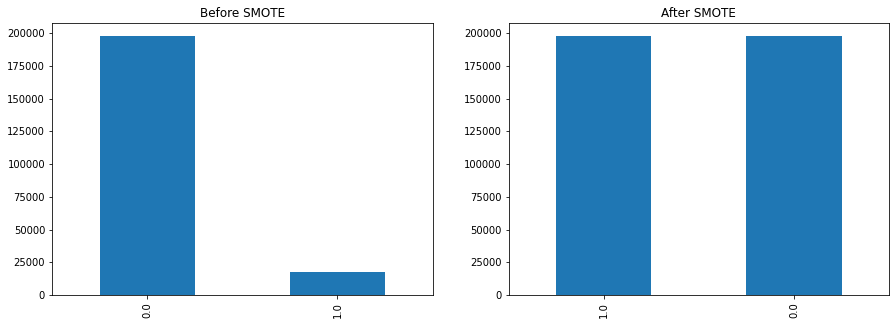

In [ ]:
sm = SMOTE()
X_train_new, y_train_new = sm.fit_resample(X_train, y_train.ravel())

# to demonstrate the effect of SMOTE over imbalanced datasets
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize =(15, 5))
ax1.set_title('Before SMOTE')
pd.Series(y_train).value_counts().plot.bar(ax=ax1)

ax2.set_title('After SMOTE')  
pd.Series(y_train_new).value_counts().plot.bar(ax=ax2)

plt.show()

In [ ]:
X_train, y_train = sm.fit_resample(X_train, y_train.ravel())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


**Scaling**
- Robust Scaler VS MinMaxScaler VS Standard Scaler

In [ ]:
scaler = RobustScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# supervised learning algorithms
from sklearn.neighbors import KNeighborsClassifier # K-Nearest Neighbbors
from sklearn.naive_bayes import GaussianNB # Gaussain Naive Bayes
from sklearn.tree import DecisionTreeClassifier # Decision Tree
from sklearn.ensemble import RandomForestClassifier # Random Forest


In [ ]:
gnb = GaussianNB()
gnb.fit(X_train,y_train)
gnb_pred = gnb.predict(X_test)

print(confusion_matrix(y_test,gnb_pred))
print('\n')
print(classification_report(y_test,gnb_pred))

[[27209 57632]
 [ 1572  5841]]


              precision    recall  f1-score   support

         0.0       0.95      0.32      0.48     84841
         1.0       0.09      0.79      0.16      7413

    accuracy                           0.36     92254
   macro avg       0.52      0.55      0.32     92254
weighted avg       0.88      0.36      0.45     92254



In [ ]:
rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train,y_train)
rfc_pred = rfc.predict(X_test)

print(confusion_matrix(y_test,rfc_pred))
print('\n')
print(classification_report(y_test,rfc_pred))

[[84841     0]
 [ 7411     2]]


              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84841
         1.0       1.00      0.00      0.00      7413

    accuracy                           0.92     92254
   macro avg       0.96      0.50      0.48     92254
weighted avg       0.93      0.92      0.88     92254

